In [1]:
!pip install -q pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.3 MB/s eta 0:00:00:00:010:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
import pickle
import scipy.stats as stats
import pycountry
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import stats
import scipy
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tools import add_constant
from collections import defaultdict, Counter
from itertools import chain, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter

In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 30

### Regional Data & Statistics

In [4]:
regions = {
    'Middle East': ['AE', 'BH', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'YE'],
    'North Africa': ['DZ', 'EG', 'LY', 'MA', 'TN'],
    'North America': ['CA', 'US'],
    'South Asia': ['BD', 'IN', 'LK', 'NP', 'PK'],
    'Caribbean': ['JM', 'PR', 'DO'],
    'Southeast Asia': ['ID', 'KH', 'LA', 'MY', 'PH', 'SG', 'TH', 'VN'],
    'East Asia': ['HK', 'JP', 'KR', 'MN', 'TW'],
    'Europe': ['AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 
               'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LI', 'LT', 'LU', 
               'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 
               'SE', 'SI', 'SK', 'UA'],
    'Latin America': ['AR', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'MX', 
                     'NI', 'PA', 'PE', 'PR', 'PY', 'SV', 'UY', 'VE'],
    'Sub-Saharan Africa': ['GH', 'KE', 'NG', 'SN', 'TZ', 'UG', 'ZA', 'ZW'],
    'Oceania': ['AU', 'NZ', 'PG'],
    'Central Asia': ['AM', 'AZ', 'GE', 'KZ'],
}

hdi_index_by_country = {
    'US': 0.927,  # United States
    #'BY': 0.801,  # Belarus
    'RS': 0.805,  # Serbia
    'LK': 0.780,  # Sri Lanka
    'DE': 0.950,  # Germany
    'KW': 0.847,  # Kuwait
    'BH': 0.888,  # Bahrain
    'MY': 0.807,  # Malaysia
    'PE': 0.762,  # Peru
    'KH': 0.600,  # Cambodia
    'ZW': 0.550,  # Zimbabwe (updated)
    'DO': 0.766,  # Dominican Republic
    'LU': 0.927,  # Luxembourg
    'RO': 0.827,  # Romania
    'EE': 0.899,  # Estonia
    'AU': 0.946,  # Australia
    'CA': 0.935,  # Canada
    'PK': 0.540,  # Pakistan (updated)
    'QA': 0.875,  # Qatar
    'BD': 0.670,  # Bangladesh
    'TH': 0.803,  # Thailand
    'EG': 0.728,  # Egypt
    'AL': 0.789,  # Albania
    'MA': 0.698,  # Morocco
    'UA': 0.734,  # Ukraine
    'TN': 0.732,  # Tunisia
    'FR': 0.910,  # France
    'DZ': 0.745,  # Algeria
    'LA': 0.620,  # Lao PDR
    'AM': 0.786,  # Armenia
    'YE': 0.424,  # Yemen (updated)
    'AZ': 0.760,  # Azerbaijan
    'ZA': 0.717,  # South Africa
    'UG': 0.550,  # Uganda (updated)
    'HN': 0.624,  # Honduras
    'CY': 0.907,  # Cyprus
    'PY': 0.731,  # Paraguay
    'BO': 0.698,  # Bolivia
    'KZ': 0.802,  # Kazakhstan
    'MD': 0.763,  # Moldova
    'LY': 0.746,  # Libya
    'VE': 0.699,  # Venezuela
    'MK': 0.765,  # North Macedonia
    'IS': 0.959,  # Iceland
    'ES': 0.911,  # Spain
    'CH': 0.967,  # Switzerland
    'ME': 0.844,  # Montenegro
    'JP': 0.920,  # Japan
    'KR': 0.929,  # Korea, Republic of
    'CZ': 0.895,  # Czech Republic
    'PR': None,   # Puerto Rico (no data provided)
    'HR': 0.878,  # Croatia
    'GT': 0.629,  # Guatemala
    'DK': 0.952,  # Denmark
    'SN': 0.517,  # Senegal (updated)
    'IL': 0.915,  # Israel
    'AR': 0.849,  # Argentina
    'SK': 0.855,  # Slovakia
    'HK': 0.956,  # Hong Kong
    'GH': 0.602,  # Ghana
    'ID': 0.713,  # Indonesia
    'HU': 0.851,  # Hungary
    'NP': 0.601,  # Nepal
    'GR': 0.893,  # Greece
    'MX': 0.781,  # Mexico
    'MN': 0.741,  # Mongolia
    'RU': 0.821,  # Russian Federation
    'LB': 0.723,  # Lebanon
    'BG': 0.799,  # Bulgaria
    'TW': 0.916,   # Taiwan (no data provided)
    'IE': 0.950,  # Ireland
    'PT': 0.874,  # Portugal
    'PA': 0.820,  # Panama
    'JO': 0.736,  # Jordan
    'NI': 0.669,  # Nicaragua
    'PH': 0.710,  # Philippines
    'NL': 0.946,  # Netherlands
    'PL': 0.881,  # Poland
    'LV': 0.879,  # Latvia
    'SG': 0.949,  # Singapore
    'IQ': 0.673,  # Iraq
    'EC': 0.765,  # Ecuador
    'SV': 0.674,  # El Salvador
    'CL': 0.860,  # Chile
    'LI': 0.942,  # Liechtenstein
    'BR': 0.760,  # Brazil
    'MT': 0.915,  # Malta
    'JM': 0.706,  # Jamaica
    'SE': 0.952,  # Sweden
    'TZ': 0.532,  # Tanzania (updated)
    #'TR': 0.855,  # Turkey
    'CR': 0.806,  # Costa Rica
    'FI': 0.942,  # Finland
    'GE': 0.814,  # Georgia
    'SA': 0.875,  # Saudi Arabia
    'PG': 0.568,  # Papua New Guinea (updated)
    'IN': 0.644,  # India
    'LT': 0.879,  # Lithuania
    'VN': 0.726,  # Vietnam
    'IT': 0.906,  # Italy
    'NZ': 0.939,  # New Zealand
    'AT': 0.926,  # Austria
    'AE': 0.937,  # United Arab Emirates
    'UY': 0.830,  # Uruguay
    'CO': 0.758,  # Colombia
    'KE': 0.601,  # Kenya
    'SI': 0.926,  # Slovenia
    'NG': 0.548,  # Nigeria (updated)
    'GB': 0.940,  # United Kingdom
    'BE': 0.942,  # Belgium
    'BA': 0.779,  # Bosnia and Herzegovina
    'OM': 0.819,  # Oman
    'NO': 0.966   # Norway
}

country_languages_official = {
    'AL': ['sq'], 'AT': ['de-AT'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE'],
    'BG': ['bg'], 'CY': ['el', 'tr'], 'CZ': ['cs'], 'DE': ['de-DE'], 'DK': ['da'], 'EE': ['et'], 'ES': ['es-ES'],
    'FI': ['fi', 'sv'], 'FR': ['fr-FR'], 'GB': ['en-GB'], 'GR': ['el'], 'HR': ['hr'], 'HU': ['hu'], 'IE': ['en-IE', 'ga'],
    'IS': ['is'], 'IT': ['it'], 'LT': ['lt'], 'LU': ['lb', 'fr-LU', 'de-LU'], 'LV': ['lv'], 'ME': ['sr-Cyrl', 'sr-Latn'],
    'MK': ['mk'], 'NL': ['nl-NL'], 'PL': ['pl'], 'PT': ['pt-PT'], 'RO': ['ro'], 'RS': ['sr-Cyrl', 'sr-Latn'], 'RU': ['ru'],
    'SE': ['sv'], 'SI': ['sl'], 'SK': ['sk'], 'UA': ['uk']
}

country_languages_widely_spoken = {
    'AL': ['sq', 'it'], 'AT': ['de-AT', 'en-GB'], 'BA': ['bs', 'hr', 'sr-Cyrl', 'sr-Latn'], 'BE': ['nl-BE', 'fr-BE', 'de-BE', 'en-GB'],
    'BG': ['bg', 'ru'], 'CY': ['el', 'tr', 'en-GB'], 'CZ': ['cs', 'de-DE', 'en-GB'], 'DE': ['de-DE', 'en-GB', 'tr'], 'DK': ['da', 'en-GB'],
    'EE': ['et', 'ru'], 'ES': ['es-ES', 'en-GB', 'ca'], 'FI': ['fi', 'sv', 'en-GB'], 'FR': ['fr-FR', 'en-GB'], 'GB': ['en-GB'],
    'GR': ['el', 'en-GB'], 'HR': ['hr', 'en-GB'], 'HU': ['hu', 'en-GB'], 'IE': ['en-IE', 'ga'], 'IS': ['is', 'en-GB'],
    'IT': ['it', 'en-GB'], 'LT': ['lt', 'ru'], 'LU': ['lb', 'fr-LU', 'de-LU', 'en-GB'], 'LV': ['lv', 'ru'], 'ME': ['sr-Cyrl', 'sr-Latn', 'ru'],
    'MK': ['mk', 'bg', 'sr-Cyrl', 'sr-Latn'], 'NL': ['nl-NL', 'en-GB'], 'PL': ['pl', 'de-DE', 'en-GB'], 'PT': ['pt-PT', 'en-GB'],
    'RO': ['ro', 'en-GB'], 'RS': ['sr-Cyrl', 'sr-Latn', 'ru'], 'RU': ['ru'], 'SE': ['sv', 'en-GB'], 'SI': ['sl', 'en-GB'], 'SK': ['sk', 'hu', 'en-GB'],
    'UA': ['uk', 'ru']
}

catid2str = {
    2 : 'Autos & Vehicles',
    1 :  'Film & Animation',
    10 : 'Music',
    15 : 'Pets & Animals',
    17 : 'Sports',
    18 : 'Short Movies',
    19 : 'Travel & Events',
    20 : 'Gaming',
    21 : 'Videoblogging',
    22 : 'People & Blogs',
    23 : 'Comedy',
    24 : 'Entertainment',
    25 : 'News & Politics',
    26 : 'Howto & Style',
    27 : 'Education',
    28 : 'Science & Technology',
    29 : 'Nonprofits & Activism',
    30 : 'Movies',
    31 : 'Anime/Animation',
    32 : 'Action/Adventure',
    33 : 'Classics',
    34 : 'Comedy',
    35 : 'Documentary',
    36 : 'Drama',
    37 : 'Family',
    38 : 'Foreign',
    39 : 'Horror',
    40 : 'Sci-Fi/Fantasy',
    41 : 'Thriller',
    42 : 'Shorts',
    43 : 'Shows',
    44 : 'Trailers'
}
country_to_iso_regions = {
    'Europe' : {
        'AL': 'ALB',  # Albania
        'AT': 'AUT',  # Austria
        'BA': 'BIH',  # Bosnia and Herzegovina
        'BE': 'BEL',  # Belgium
        'BG': 'BGR',  # Bulgaria
        'CH': 'CHE',  # Switzerland
        'CY': 'CYP',  # Cyprus
        'CZ': 'CZE',  # Czech Republic
        'DE': 'DEU',  # Germany
        'DK': 'DNK',  # Denmark
        'EE': 'EST',  # Estonia
        'ES': 'ESP',  # Spain
        'FI': 'FIN',  # Finland
        'FR': 'FRA',  # France
        'GB': 'GBR',  # United Kingdom
        'GR': 'GRC',  # Greece
        'HR': 'HRV',  # Croatia
        'HU': 'HUN',  # Hungary
        'IE': 'IRL',  # Ireland
        'IS': 'ISL',  # Iceland
        'IT': 'ITA',  # Italy
        'LI': 'LIE',  # Liechtenstein
        'LT': 'LTU',  # Lithuania
        'LU': 'LUX',  # Luxembourg
        'LV': 'LVA',  # Latvia
        'MD': 'MDA',  # Moldova
        'ME': 'MNE',  # Montenegro
        'MK': 'MKD',  # North Macedonia
        'MT': 'MLT',  # Malta
        'NL': 'NLD',  # Netherlands
        'NO': 'NOR',  # Norway
        'PL': 'POL',  # Poland
        'PT': 'PRT',  # Portugal
        'RO': 'ROU',  # Romania
        'RS': 'SRB',  # Serbia
        'RU': 'RUS',  # Russia
        'SE': 'SWE',  # Sweden
        'SI': 'SVN',  # Slovenia
        'SK': 'SVK',  # Slovakia
        'UA': 'UKR'   # Ukraine
    },
    'Middle East' : {
        'AE': 'ARE',  # United Arab Emirates
        'BH': 'BHR',  # Bahrain
        'IQ': 'IRQ',  # Iraq
        'IL': 'ISR',  # Israel
        'JO': 'JOR',  # Jordan
        'KW': 'KWT',  # Kuwait
        'LB': 'LBN',  # Lebanon
        'OM': 'OMN',  # Oman
        'QA': 'QAT',  # Qatar
        'SA': 'SAU',  # Saudi Arabia
        'YE': 'YEM'   # Yemen
    },
    'North Africa': {
        'DZ': 'DZA',  # Algeria
        'EG': 'EGY',  # Egypt
        'LY': 'LBY',  # Libya
        'MA': 'MAR',  # Morocco
        'TN': 'TUN'   # Tunisia
    },
    'North America' : {
        'CA': 'CAN',  # Canada
        'US': 'USA'   # United States of America
    },
    'South Asia': {
    'BD': 'BGD',  # Bangladesh
    'IN': 'IND',  # India
    'LK': 'LKA',  # Sri Lanka
    'NP': 'NPL',  # Nepal
    'PK': 'PAK'   # Pakistan
},
'Caribbean':{
    'JM': 'JAM',  # Jamaica
    'PR': 'PRI',  # Puerto Rico
    'DO': 'DOM'   # Dominican Republic
},
'Southeast Asia': {
    'ID': 'IDN',  # Indonesia
    'KH': 'KHM',  # Cambodia
    'LA': 'LAO',  # Laos
    'MY': 'MYS',  # Malaysia
    'PH': 'PHL',  # Philippines
    'SG': 'SGP',  # Singapore
    'TH': 'THA',  # Thailand
    'VN': 'VNM'   # Vietnam
},
'East Asia': {
    'HK': 'HKG',  # Hong Kong
    'JP': 'JPN',  # Japan
    'KR': 'KOR',  # South Korea
    'MN': 'MNG',  # Mongolia
    'TW': 'TWN'   # Taiwan
},
'Latin America':{
    'AR': 'ARG',  # Argentina
    'BO': 'BOL',  # Bolivia
    'BR': 'BRA',  # Brazil
    'CL': 'CHL',  # Chile
    'CO': 'COL',  # Colombia
    'CR': 'CRI',  # Costa Rica
    'DO': 'DOM',  # Dominican Republic
    'EC': 'ECU',  # Ecuador
    'GT': 'GTM',  # Guatemala
    'HN': 'HND',  # Honduras
    'MX': 'MEX',  # Mexico
    'NI': 'NIC',  # Nicaragua
    'PA': 'PAN',  # Panama
    'PE': 'PER',  # Peru
    'PR': 'PRI',  # Puerto Rico
    'PY': 'PRY',  # Paraguay
    'SV': 'SLV',  # El Salvador
    'UY': 'URY',  # Uruguay
    'VE': 'VEN'   # Venezuela
},
'Sub-Saharan Africa':{
    'GH': 'GHA',  # Ghana
    'KE': 'KEN',  # Kenya
    'NG': 'NGA',  # Nigeria
    'SN': 'SEN',  # Senegal
    'TZ': 'TZA',  # Tanzania
    'UG': 'UGA',  # Uganda
    'ZA': 'ZAF',  # South Africa
    'ZW': 'ZWE'   # Zimbabwe
},
'Oceania':{
    'AU': 'AUS',  # Australia
    'NZ': 'NZL',  # New Zealand
    'PG': 'PNG'   # Papua New Guinea
},
'Central Asia': {
    'AM': 'ARM',  # Armenia
    'AZ': 'AZE',  # Azerbaijan
    'GE': 'GEO',  # Georgia
    'KZ': 'KAZ'   # Kazakhstan
}    
}

### Data Loading

In [5]:
def filter_dataframe(df):
    return df.query("view_count < 0.5e9 and days_after_pub_to_first_trend >= 0").reset_index(drop=True)

def load_country_data(country_code):
    """Load data for a specific country and return emoji usage statistics"""
    try:
        df = pd.read_csv(f"..dat/dataset_with_features_{country_code}.csv")
        df = filter_dataframe(df)
        return df
    except FileNotFoundError:
        print(f"No data found for {country_code}")
        return None
full_dataset_by_country = {}
for region in tqdm(regions):
    for country_code in regions[region]:
        df = load_country_data(country_code)
        full_dataset_by_country[country_code] = (df.iloc[df['video_id'].drop_duplicates().index]).reset_index(drop=True)

100%|██████████| 12/12 [01:37<00:00,  8.11s/it]


# 2. Human Development Index relation to length of title in trending video

Here we wanted to check hypothesis "Does HDI affect length of titles?". Intuitively they may be related to do literacy rate and people preferences.

For each country we choose only country-specific trending videos and count mean length of words in title.
Specifically, we cared about conditions:

-  Independence of Observations (we take contry-specific videos with no overlap between videos and no duplicates, we filter channels so that we have only country-specific videos after all and only one randm video for channel)
-  We have many observations (> 50)
-  We take only countries with enough videos (> 30)


In [16]:
def prepare_regression_data(hdi_index: dict, min_channels: int = 30) -> tuple[list, list]:
    """
    Prepares country-level data for regression analysis of HDI vs word count.
    This makes sure that observations will be independent.
    
    Args:
        hdi_index: Dictionary mapping country codes to HDI values
        min_channels: Minimum number of channels required per country
        
    Returns:
        Tuple of (x_values, y_values) for regression analysis
    """
    all_channels = chain.from_iterable(
        df['channel_id'].unique() 
        for df in full_dataset_by_country.values()
    )
    
    channel_counts = Counter(all_channels)
    country_specific = {cid for cid, count in channel_counts.items() if count == 1}
    
    country_data = {
        country: df[df['channel_id'].isin(country_specific)]
            .drop_duplicates('channel_id')
            .groupby('channel_id', as_index=False)
            .first()
        for country, df in full_dataset_by_country.items()
        if len(df['channel_id'].isin(country_specific)) >= min_channels
    }
    
    x_vals, y_vals = [], []
    for country, df in country_data.items():
        try:
            hdi = float(hdi_index[country])
            if np.isnan(hdi):
                continue
            word_counts = df['total_words'].astype(float)
            if len(word_counts) == 0:
                continue
            x_vals.append(hdi)
            y_vals.append(np.nanmean(word_counts))
        except (KeyError, ValueError, TypeError):
            continue
    
    return x_vals, y_vals

We preparing the data, runn linear regression, and compute residuals.

In [17]:
x, y = prepare_regression_data(hdi_index_by_country, min_channels=30)
x = np.array(x)
y = np.array(y)
slope, intercept, r_value, p_value, _ = stats.linregress(x, y, alternative='less')

# Calculate predictions and residuals
y_pred = intercept + slope * x
residuals = y - y_pred

This plot helps us see if residuals are randomly scattered. If there's a pattern, it suggests non-linearity in our regression.

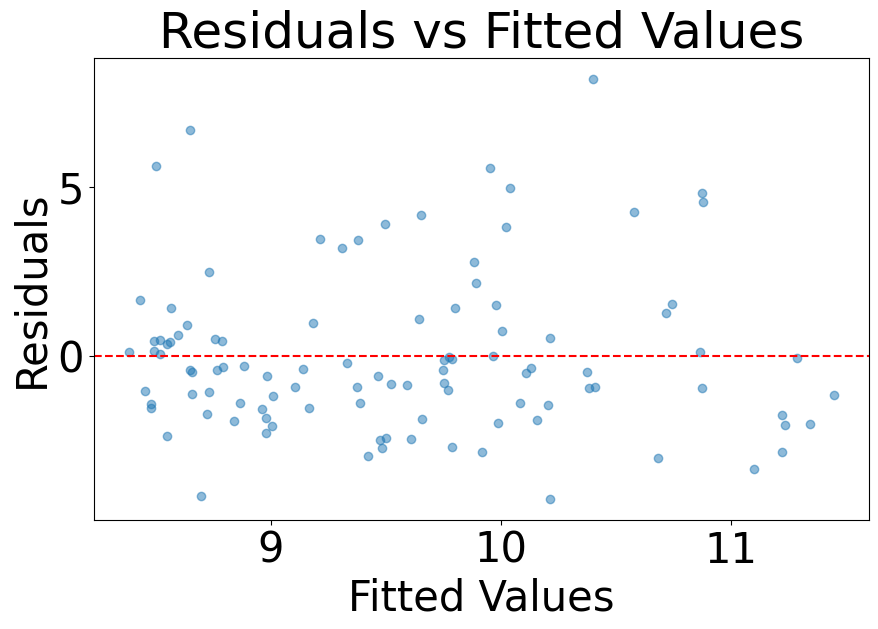

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

We check if residuals are autocorrelated. A Durbin-Watson statistic between 1.5 and 2.5 suggests little to no autocorrelation.

In [19]:
dw = durbin_watson(residuals)
print(f"\nDurbin-Watson statistic: {dw:.2f}")


Durbin-Watson statistic: 1.52


Homoscedasticity means residuals have constant variance. If the p-value < 0.05, it suggests heteroscedasticity (unequal variance), which can be a problem.

In [20]:
X = add_constant(x)
_, p_bp, _, _ = het_breuschpagan(residuals, X)
print(f"\nBreusch-Pagan p-value: {p_bp:.4f}")


Breusch-Pagan p-value: 0.1400


<Figure size 1000x600 with 0 Axes>

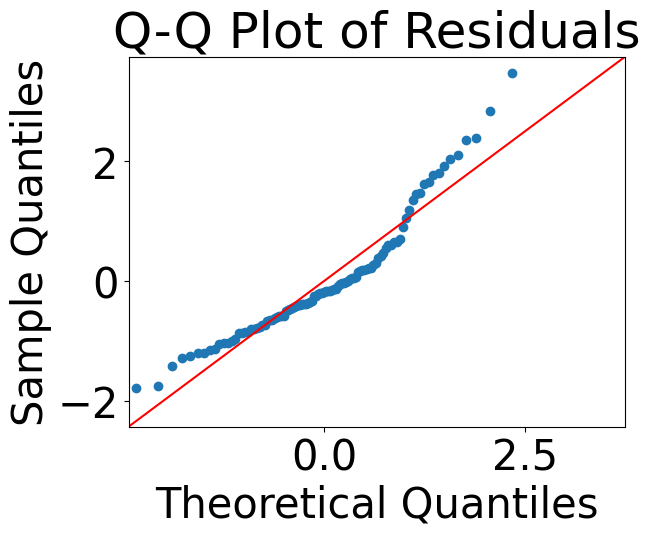


Shapiro-Wilk p-value: 0.0000
(H0: Normality, p < 0.05 suggests non-normal residuals)


In [21]:
plt.figure(figsize=(10, 6))
qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
if len(residuals) < 5000:
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk p-value: {shapiro_p:.4f}")
    print("(H0: Normality, p < 0.05 suggests non-normal residuals)")
else:
    print("\nSample too large for Shapiro-Wilk (use Q-Q plot instead)")

Since the number of ties is low, they won't significantly affect our experiments using Kendall's Tau and Spearman's Rank Correlation. Both methods can handle ties, and with such a small amount, the impact on results should be minimal.

In [22]:
def count_ties(data):
    unique, counts = np.unique(data, return_counts=True)
    return np.sum(counts[counts > 1] - 1)  # Subtract 1 to count duplicates

print(f"Ties in x: {count_ties(x)}")
print(f"Ties in y: {count_ties(y)}")
# Therefore, we can use Kendall Tau

Ties in x: 13
Ties in y: 2


In [23]:
scipy.stats.kendalltau(x, y)

SignificanceResult(statistic=-0.24554393442139744, pvalue=0.0002421292864315084)

In [24]:
pvalue_k = scipy.stats.kendalltau(x, y).pvalue
tau = scipy.stats.kendalltau(x, y).statistic
print(f"Statistics {tau}")

Statistics -0.24554393442139744


In [25]:
pvalue_s = scipy.stats.spearmanr(x, y).pvalue
rho = scipy.stats.spearmanr(x, y).statistic
print(f"Statistics {rho}")

Statistics -0.36866716290879625


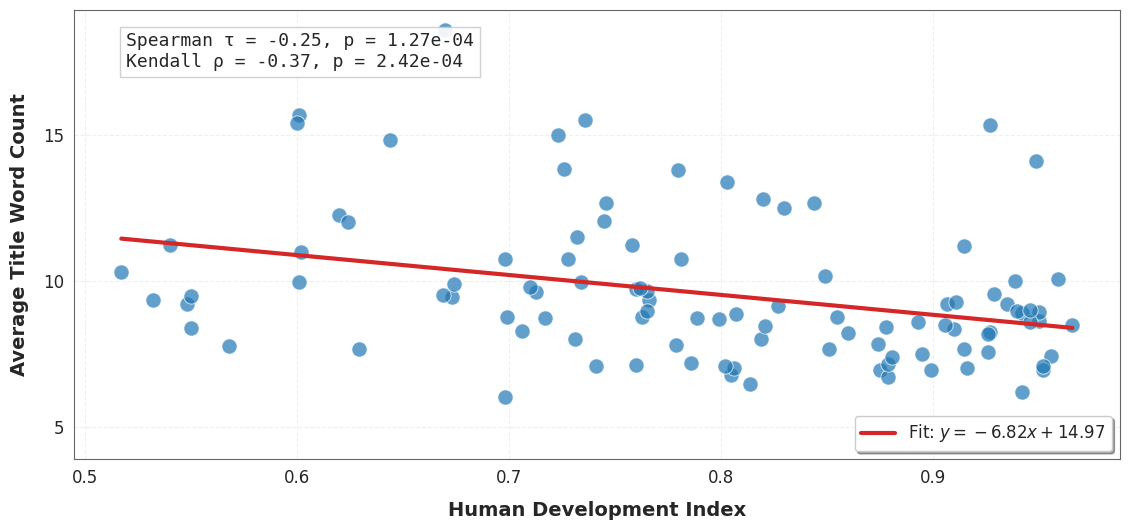

In [26]:
def enhanced_scatter_plot(x, y, pvalue_s, pvalue_k, tau, rho, 
                          xlabel='HDI', ylabel='Words count', 
                          title='Mean Words Count vs HDI Index', figsize=(12, 8)):
    """Creates a clean, well-styled scatter plot with regression line and correlation stats."""
    
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})
    plt.scatter( x, y, alpha=0.7, color='#2077B4', edgecolor='w', linewidth=0.7, s=120, zorder=2)
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    line_x = np.linspace(min(x), max(x), 100)
    line_y = slope * line_x + intercept
    plt.plot(line_x, line_y, color='#D62728', lw=3, label=f'Fit: $y = {slope:.2f}x + {intercept:.2f}$', zorder=3)
    stats_text = f'Spearman τ = {tau:.2f}, p = {pvalue_s:.2e}\nKendall ρ = {rho:.2f}, p = {pvalue_k:.2e}'
    plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=13, fontfamily='monospace', bbox=dict(facecolor='white', alpha=0.9, edgecolor='0.8'), verticalalignment='top')
    plt.xlabel(xlabel, fontsize=14, labelpad=10, fontweight='semibold')
    plt.ylabel(ylabel, fontsize=14, labelpad=10, fontweight='semibold')
    
    if title:
        plt.title(title, fontsize=16, pad=20, fontweight='bold', color='#2C2C2C')
        
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(frameon=True, shadow=True, fontsize=12, loc='upper left' if slope > 0 else 'lower right')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    

enhanced_scatter_plot(
    *prepare_regression_data(hdi_index_by_country, min_channels=30),
    pvalue_k=pvalue_k, pvalue_s=pvalue_s,
    tau=tau, rho=rho,
    xlabel='Human Development Index',
    ylabel='Average Title Word Count',
    title='',  # 'Content Complexity vs National Development Level',
    figsize=(12, 6)
)

plt.savefig('experiment2_visualization_1.pdf', bbox_inches='tight', pad_inches=0)
